In [16]:
# Import libraries
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # data visualization
from matplotlib import pyplot as plt

In [17]:
# Get the medal details dataset
df_medal_details = pd.read_csv('../data/etl/medals_by_season_country_discip_event_type.csv')
df_medal_details.head()

,game_season,country_code,country_name,discipline_title,event_title,event_gender,medal_type,medal_count
0,Summer,AFG,Afghanistan,Taekwondo,58 - 68 kg men,Men,BRONZE,1
1,Summer,AFG,Afghanistan,Taekwondo,beijing 2008 taekwondo - 58 kg men,Men,BRONZE,1
2,Summer,AHO,Netherlands Antilles,Sailing,division ii - windsurfer men,Open,SILVER,1
3,Summer,ALG,Algeria,Athletics,1500m men,Men,GOLD,2
4,Summer,ALG,Algeria,Athletics,1500m men,Men,SILVER,1


In [18]:
# Get all of the other datasets in the etl folder
df_hapiness = pd.read_csv('../data/etl/happiness_avg_by_country.csv')
df_gdp = pd.read_csv('../data/etl/gdp_avg_by_country.csv')
df_nutrition = pd.read_csv('../data/etl/nutrition_2017_by_country.csv')


In [19]:
# Function to merge a medals slice with the other datasets
def merge_hap_gdp_nut(df_medal_slice: pd.DataFrame) -> pd.DataFrame:
    df_merged = pd.merge(df_medal_slice, df_hapiness, left_on='country_name', right_on='country', how='left')
    df_merged = pd.merge(df_merged, df_gdp, on='country_name', how='left')
    df_merged = pd.merge(df_merged, df_nutrition, on='country_name', how='left')
    df_merged = df_merged.drop(columns=['country', 'country_code']).reset_index(drop=True)
    return df_merged

In [20]:
# Function to slice the medal details dataset and prepare it for correlation
def slice_medal_details_data(data_to_select: dict[str, str]) -> pd.DataFrame:
    drop_medal_cols = ['game_season', 'country_code', 'discipline_title', 'event_title', 'event_gender', 'medal_type']
    group_medal_cols = ['country_name']

    df_slice = df_medal_details.copy()
    for key, value in data_to_select.items():
        df_slice = df_slice[df_slice[key] == value]

    df_slice = df_slice.drop(columns=drop_medal_cols)
    df_slice = df_slice.groupby(group_medal_cols)['medal_count'].sum().reset_index()
    return df_slice.reset_index(drop=True)

In [51]:
def remove_outliers(df: pd.DataFrame) -> pd.DataFrame:
    # Use pandas to find potential outliers by calculating the interquartile range (IQR)
    medals = df['medal_count']
    Q1 = medals.quantile(0.25)
    median = medals.quantile(0.5)
    Q3 = medals.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - (2 * IQR)
    upper_bound = Q3 + (2 * IQR)
    return lower_bound, upper_bound
    
    # print(upper_bound, lower_bound)
    
    # # Remove outliers
    # outlier_df = df.loc[(df['medal_count'] < upper_bound) |
    #                             (df['medal_count'] > lower_bound)]
    # return outlier_df

In [69]:
def custom_outliers(df: pd.DataFrame) -> pd.DataFrame:
    # Use pandas to find potential outliers by calculating the interquartile range (IQR)
    medals = df['medal_count']
    Q1 = medals.quantile(0.25)
    median = medals.quantile(0.5)
    Q3 = medals.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 * 5
    upper_bound = df['medal_count'].max()
    return lower_bound, upper_bound
    
    # print(upper_bound, lower_bound)
    
    # # Remove outliers
    # outlier_df = df.loc[(df['medal_count'] < upper_bound) |
    #                             (df['medal_count'] > lower_bound)]
    # return outlier_df

In [57]:
def box_plot_medals(df: pd.DataFrame, title: str) -> None:
    medals = df['medal_count']
    fig1, ax1 = plt.subplots()
    ax1.set_title(title)
    ax1.set_ylabel('Medal Count')
    ax1.boxplot(medals)
    plt.show()

In [70]:
# Women's summer games correlation
data_to_select = {
    'game_season': 'Summer', 
    'event_gender': 'Women'
}
df = slice_medal_details_data(data_to_select)
df = merge_hap_gdp_nut(df)
df.set_index('country_name').corr()

,medal_count,happiness,wealth,support,health,freedom,generosity,corruption,positivity,negativity,gdp_avg,calories_pct,nutrients_pct,diet_pct,calories_mills,nutrients_mills,diet_mills,population
medal_count,1.000000,0.220567,0.281945,0.185370,0.165661,0.096996,0.058168,-0.077640,0.105476,-0.179493,0.881499,-0.130647,-0.214235,-0.250582,-0.046197,-0.026145,-0.010255,0.332949
happiness,0.220567,1.000000,0.800538,0.730530,0.754235,0.600304,0.371587,-0.599141,0.573452,-0.280796,0.202401,-0.485815,-0.671955,-0.732227,-0.229304,-0.255856,-0.257787,-0.178021
wealth,0.281945,0.800538,1.000000,0.696210,0.844669,0.418890,0.124312,-0.452280,0.268432,-0.211463,0.217943,-0.611164,-0.864317,-0.889854,-0.289587,-0.255434,-0.252844,-0.161100
support,0.185370,0.730530,0.696210,1.000000,0.573535,0.406149,0.233989,-0.302176,0.429864,-0.371542,0.110141,-0.574935,-0.658879,-0.664701,-0.269283,-0.386308,-0.386925,-0.285352
health,0.165661,0.754235,0.844669,0.573535,1.000000,0.338940,0.102161,-0.396567,0.254752,-0.113009,0.154807,-0.697495,-0.866325,-0.860756,-0.397369,-0.247334,-0.234873,-0.102165
freedom,0.096996,0.600304,0.418890,0.406149,0.338940,1.000000,0.512530,-0.569262,0.665437,-0.312787,0.141564,-0.378647,-0.300344,-0.333578,-0.109365,0.022504,0.028254,0.080720
generosity,0.058168,0.371587,0.124312,0.233989,0.102161,0.512530,1.000000,-0.384608,0.480634,-0.226598,0.080943,0.021643,0.080594,0.094091,0.106995,0.085951,0.087360,-0.005631
corruption,-0.077640,-0.599141,-0.452280,-0.302176,-0.396567,-0.569262,-0.384608,1.000000,-0.347213,0.363675,-0.068265,0.185861,0.298415,0.361399,0.158773,0.113180,0.115305,0.113944
positivity,0.105476,0.573452,0.268432,0.429864,0.254752,0.665437,0.480634,-0.347213,1.000000,-0.219059,0.181748,-0.030678,-0.051646,-0.107617,0.077176,-0.053205,-0.051250,0.015320
negativity,-0.179493,-0.280796,-0.211463,-0.371542,-0.113009,-0.312787,-0.226598,0.363675,-0.219059,1.000000,-0.061065,0.037616,0.218731,0.216874,0.024488,0.156953,0.144600,-0.001121


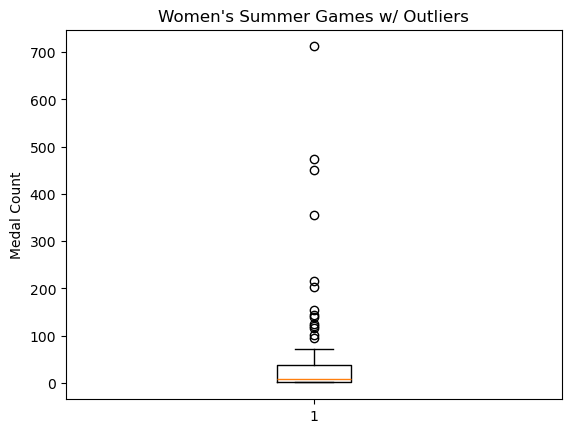

In [71]:
# Create a boxplot to visualize the filtered dataset
box_plot_medals(df, 'Women\'s Summer Games w/ Outliers')


In [72]:
df.reset_index(drop=True, inplace=True)
df = df.sort_values(by='medal_count', ascending=False)
display(df.head())
display(df.tail())

,country_name,medal_count,happiness,wealth,support,health,freedom,generosity,corruption,positivity,negativity,gdp_avg,calories_pct,nutrients_pct,diet_pct,calories_mills,nutrients_mills,diet_mills,population
97,United States,712,7.029156,10.976059,0.915736,66.399999,0.829080,0.182304,0.690821,0.752731,0.264086,8536365.96,1.2,1.5,2.0,4.1,4.9,6.5,3.251221e+08
74,Russia,473,5.564873,10.148258,0.897139,62.349999,0.679709,-0.193543,0.883493,0.590380,0.180509,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36,Germany,451,6.822410,10.824794,0.919011,70.448889,0.858239,0.080415,0.558557,0.698333,0.206088,1857701.61,0.0,0.2,0.2,0.0,0.2,0.2,8.265700e+07
18,China,356,5.160455,9.340597,0.789619,67.525000,0.843813,-0.154764,NaN,0.691941,0.170754,3291242.38,0.2,8.0,14.3,2.3,111.7,199.3,1.396215e+09
3,Australia,216,7.242307,10.764977,0.942319,70.570588,0.914413,0.254107,0.429199,0.737576,0.218661,521918.13,0.2,0.5,0.7,0.1,0.1,0.2,2.460186e+07


,country_name,medal_count,happiness,wealth,support,health,freedom,generosity,corruption,positivity,negativity,gdp_avg,calories_pct,nutrients_pct,diet_pct,calories_mills,nutrients_mills,diet_mills,population
17,Chile,1,6.357284,10.051550,0.854962,69.250000,0.740900,0.063515,0.780703,0.756309,0.298783,94857.75,0.2,1.2,3.4,0.0,0.2,0.6,18470435.0
85,Sri Lanka,1,4.263359,9.297134,0.826207,65.535294,0.802164,0.133455,0.828399,0.721293,0.240173,25338.77,0.4,19.4,52.3,0.1,4.2,11.2,21444000.0
44,Iran,1,4.875571,9.590507,0.685560,65.731250,0.671842,0.158303,0.725207,0.536809,0.457747,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68,Peru,1,5.601965,9.313264,0.800963,68.500000,0.749006,-0.107918,0.885636,0.747838,0.371522,102416.78,2.2,14.5,23.7,0.7,4.6,7.5,31444299.0
54,Latvia,1,5.569637,10.204665,0.886316,65.305882,0.673703,-0.113089,0.856114,0.598389,0.220305,23121.80,0.2,1.7,3.4,0.0,0.0,0.1,1942248.0


10.0 712


,country_name,medal_count,happiness,wealth,support,health,freedom,generosity,corruption,positivity,negativity,gdp_avg,calories_pct,nutrients_pct,diet_pct,calories_mills,nutrients_mills,diet_mills,population
97,United States,712,7.029156,10.976059,0.915736,66.399999,0.829080,0.182304,0.690821,0.752731,0.264086,8536365.96,1.2,1.5,2.0,4.1,4.9,6.5,3.251221e+08
74,Russia,473,5.564873,10.148258,0.897139,62.349999,0.679709,-0.193543,0.883493,0.590380,0.180509,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36,Germany,451,6.822410,10.824794,0.919011,70.448889,0.858239,0.080415,0.558557,0.698333,0.206088,1857701.61,0.0,0.2,0.2,0.0,0.2,0.2,8.265700e+07
18,China,356,5.160455,9.340597,0.789619,67.525000,0.843813,-0.154764,NaN,0.691941,0.170754,3291242.38,0.2,8.0,14.3,2.3,111.7,199.3,1.396215e+09
3,Australia,216,7.242307,10.764977,0.942319,70.570588,0.914413,0.254107,0.429199,0.737576,0.218661,521918.13,0.2,0.5,0.7,0.1,0.1,0.2,2.460186e+07


,country_name,medal_count,happiness,wealth,support,health,freedom,generosity,corruption,positivity,negativity,gdp_avg,calories_pct,nutrients_pct,diet_pct,calories_mills,nutrients_mills,diet_mills,population
5,Azerbaijan,13,4.935251,9.527749,0.760488,62.507812,0.681153,-0.158288,0.693731,0.518247,0.240791,30686.34,0.0,0.0,0.0,0.0,0.0,0.0,9854033.0
1,Argentina,13,6.289722,10.028808,0.901894,66.700000,0.777786,-0.153203,0.839019,0.737995,0.288382,317986.22,0.3,7.1,11.0,0.1,3.1,4.8,44044811.0
65,Nigeria,12,4.983039,8.490657,0.758219,53.031250,0.688673,0.075431,0.896963,0.734424,0.232661,160300.71,55.3,78.1,94.1,105.6,149.0,179.7,190873247.0
92,Turkey,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33,Finland,11,7.624132,10.761079,0.951761,70.442501,0.942584,0.001391,0.237706,0.737589,0.185152,125374.08,0.1,0.1,0.1,0.0,0.0,0.0,5508214.0


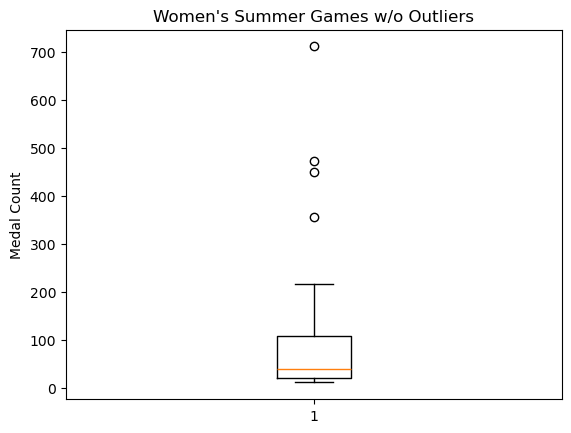

In [75]:
# Remove outliers
lower, upper = custom_outliers(df)
print(lower, upper)

# Remove outliers
outlier_df = df[(df['medal_count'] <= upper) & (df['medal_count'] > lower)]

display(outlier_df.head())
display(outlier_df.tail())
# df.sort_values(by='medal_count', ascending=False)
# df.head()
box_plot_medals(outlier_df, 'Women\'s Summer Games w/o Outliers')


In [76]:
outlier_df.set_index('country_name').corr()


,medal_count,happiness,wealth,support,health,freedom,generosity,corruption,positivity,negativity,gdp_avg,calories_pct,nutrients_pct,diet_pct,calories_mills,nutrients_mills,diet_mills,population
medal_count,1.000000,0.105508,0.247591,0.105445,0.101609,0.063989,0.022777,0.007529,-0.011816,-0.113193,0.875473,-0.155798,-0.231050,-0.232376,-0.098758,-0.017775,0.035652,0.443277
happiness,0.105508,1.000000,0.826610,0.720122,0.717575,0.679268,0.379499,-0.801749,0.619631,-0.168941,0.156548,-0.436139,-0.632680,-0.647141,-0.313911,-0.498949,-0.479574,-0.228419
wealth,0.247591,0.826610,1.000000,0.801805,0.801257,0.452772,0.096276,-0.590152,0.249464,-0.181381,0.221533,-0.551188,-0.840072,-0.859090,-0.443896,-0.661388,-0.616610,-0.235958
support,0.105445,0.720122,0.801805,1.000000,0.601337,0.302476,0.163067,-0.568180,0.328217,-0.177391,0.063796,-0.477909,-0.691365,-0.709439,-0.417285,-0.667556,-0.643709,-0.326374
health,0.101609,0.717575,0.801257,0.601337,1.000000,0.323142,0.084233,-0.509692,0.193146,-0.024140,0.138349,-0.742582,-0.826779,-0.802609,-0.583997,-0.601039,-0.517510,-0.090004
freedom,0.063989,0.679268,0.452772,0.302476,0.323142,1.000000,0.579318,-0.761898,0.710774,-0.410676,0.130122,-0.284285,-0.302361,-0.294036,-0.230331,-0.179628,-0.137250,0.027362
generosity,0.022777,0.379499,0.096276,0.163067,0.084233,0.579318,1.000000,-0.432459,0.609389,-0.189768,0.053355,0.067825,0.137298,0.173970,0.096388,0.193209,0.186786,-0.076864
corruption,0.007529,-0.801749,-0.590152,-0.568180,-0.509692,-0.761898,-0.432459,1.000000,-0.478177,0.454787,-0.018538,0.278036,0.423037,0.453874,0.219967,0.320399,0.324430,0.298250
positivity,-0.011816,0.619631,0.249464,0.328217,0.193146,0.710774,0.609389,-0.478177,1.000000,-0.167485,0.164780,0.095364,0.071827,0.079002,0.096676,0.102151,0.104629,0.060079
negativity,-0.113193,-0.168941,-0.181381,-0.177391,-0.024140,-0.410676,-0.189768,0.454787,-0.167485,1.000000,0.018571,0.015058,0.147691,0.145421,0.021698,0.023590,-0.020288,-0.137503


In [7]:
# Men's summer games correlation
data_to_select = {
    'game_season': 'Summer', 
    'event_gender': 'Men'
}
df = slice_medal_details_data(data_to_select)
df = merge_hap_gdp_nut(df)
df.set_index('country_name').corr()

,medal_count,happiness,wealth,support,health,freedom,generosity,corruption,positivity,negativity,gdp_avg,calories_pct,nutrients_pct,diet_pct,calories_mills,nutrients_mills,diet_mills,population
medal_count,1.000000,0.286152,0.311658,0.256384,0.229474,0.101528,0.062909,-0.109791,0.105766,-0.170985,0.880245,-0.130152,-0.260996,-0.299767,-0.037227,-0.047080,-0.046275,0.182180
happiness,0.286152,1.000000,0.823836,0.770007,0.754181,0.641247,0.311525,-0.566027,0.604142,-0.400111,0.212997,-0.432776,-0.702836,-0.758333,-0.194060,-0.213117,-0.217071,-0.125543
wealth,0.311658,0.823836,1.000000,0.737211,0.805708,0.507321,0.089656,-0.466568,0.304324,-0.292064,0.208667,-0.537688,-0.855952,-0.880160,-0.251244,-0.223132,-0.227144,-0.126450
support,0.256384,0.770007,0.737211,1.000000,0.662756,0.505662,0.138701,-0.292758,0.511181,-0.489513,0.144820,-0.485464,-0.682318,-0.708886,-0.209221,-0.326269,-0.339956,-0.203769
health,0.229474,0.754181,0.805708,0.662756,1.000000,0.421536,0.016419,-0.343857,0.265692,-0.211164,0.176495,-0.608847,-0.854511,-0.852125,-0.308580,-0.186125,-0.182539,-0.049579
freedom,0.101528,0.641247,0.507321,0.505662,0.421536,1.000000,0.377863,-0.534956,0.699538,-0.469324,0.144871,-0.289048,-0.367472,-0.425796,-0.089364,0.005977,-0.001146,0.065170
generosity,0.062909,0.311525,0.089656,0.138701,0.016419,0.377863,1.000000,-0.343858,0.399557,-0.192190,0.080280,0.057865,0.092275,0.083608,0.102471,0.085391,0.089437,0.002773
corruption,-0.109791,-0.566027,-0.466568,-0.292758,-0.343857,-0.534956,-0.343858,1.000000,-0.301265,0.347987,-0.068001,0.165072,0.283382,0.339647,0.144347,0.105131,0.108874,0.106490
positivity,0.105766,0.604142,0.304324,0.511181,0.265692,0.699538,0.399557,-0.301265,1.000000,-0.409029,0.154347,-0.024942,-0.096600,-0.192429,0.065177,-0.064367,-0.075932,-0.002822
negativity,-0.170985,-0.400111,-0.292064,-0.489513,-0.211164,-0.469324,-0.192190,0.347987,-0.409029,1.000000,-0.091791,0.054114,0.195467,0.242895,0.005483,0.117318,0.116642,-0.009489


In [8]:
# Women's Winter games correlation
data_to_select = {
    'game_season': 'Winter', 
    'event_gender': 'Women'
}
df = slice_medal_details_data(data_to_select)
df = merge_hap_gdp_nut(df)
df.set_index('country_name').corr()

,medal_count,happiness,wealth,support,health,freedom,generosity,corruption,positivity,negativity,gdp_avg,calories_pct,nutrients_pct,diet_pct,calories_mills,nutrients_mills,diet_mills,population
medal_count,1.000000,0.305781,0.379829,0.047605,0.121792,0.157005,0.274290,-0.157356,0.278741,-0.080606,0.527280,0.122481,-0.110806,-0.161011,0.328498,0.023255,0.017492,0.135200
happiness,0.305781,1.000000,0.790483,0.659487,0.632986,0.758239,0.783163,-0.849389,0.851233,-0.055120,0.025456,-0.154491,-0.655547,-0.704460,-0.130052,-0.363904,-0.365384,-0.347775
wealth,0.379829,0.790483,1.000000,0.466480,0.734365,0.391079,0.469058,-0.493358,0.553559,0.160907,0.128217,0.091643,-0.653059,-0.715188,-0.101549,-0.584662,-0.587407,-0.531063
support,0.047605,0.659487,0.466480,1.000000,0.208168,0.587686,0.519851,-0.630802,0.546229,-0.019501,-0.228136,-0.192005,-0.808519,-0.836265,-0.379157,-0.735166,-0.734997,-0.722391
health,0.121792,0.632986,0.734365,0.208168,1.000000,0.414117,0.372417,-0.452025,0.531143,0.214241,-0.003084,0.135139,-0.285962,-0.337474,-0.154495,-0.159678,-0.157132,-0.163093
freedom,0.157005,0.758239,0.391079,0.587686,0.414117,1.000000,0.685943,-0.832216,0.866862,-0.393823,-0.022218,-0.379524,-0.433346,-0.456897,-0.087872,0.005954,0.007347,-0.019175
generosity,0.274290,0.783163,0.469058,0.519851,0.372417,0.685943,1.000000,-0.722933,0.746108,-0.060633,0.062877,-0.119886,-0.400173,-0.461060,0.000123,-0.240134,-0.243644,-0.218890
corruption,-0.157356,-0.849389,-0.493358,-0.630802,-0.452025,-0.832216,-0.722933,1.000000,-0.844109,0.470156,0.111832,0.346824,0.552962,0.597746,0.169277,0.250059,0.277185,0.205733
positivity,0.278741,0.851233,0.553559,0.546229,0.531143,0.866862,0.746108,-0.844109,1.000000,-0.271562,0.204190,-0.038681,-0.347937,-0.399761,0.146094,0.013548,0.011857,0.035181
negativity,-0.080606,-0.055120,0.160907,-0.019501,0.214241,-0.393823,-0.060633,0.470156,-0.271562,1.000000,0.122421,0.314977,0.007503,-0.027841,0.059522,-0.238843,-0.243408,-0.184116


In [9]:
# Men's Winter games correlation
data_to_select = {
    'game_season': 'Winter', 
    'event_gender': 'Men'
}
df = slice_medal_details_data(data_to_select)
df = merge_hap_gdp_nut(df)
df.set_index('country_name').corr()

,medal_count,happiness,wealth,support,health,freedom,generosity,corruption,positivity,negativity,gdp_avg,calories_pct,nutrients_pct,diet_pct,calories_mills,nutrients_mills,diet_mills,population
medal_count,1.000000,0.516516,0.451951,0.293444,0.238153,0.399912,0.422890,-0.432350,0.491571,-0.237792,0.309797,0.054660,-0.280965,-0.326897,0.165228,-0.087738,-0.090958,-0.013935
happiness,0.516516,1.000000,0.855739,0.619853,0.671654,0.816312,0.817945,-0.870666,0.868447,-0.112116,0.070437,-0.179222,-0.617064,-0.680839,-0.070633,-0.313996,-0.315253,-0.282448
wealth,0.451951,0.855739,1.000000,0.543387,0.710936,0.635427,0.647812,-0.715168,0.708945,-0.023246,0.082221,-0.010045,-0.601572,-0.671690,-0.084457,-0.502051,-0.503990,-0.452512
support,0.293444,0.619853,0.543387,1.000000,0.278401,0.517815,0.522000,-0.608719,0.539141,-0.119085,-0.123654,-0.317150,-0.865745,-0.874108,-0.278306,-0.592236,-0.590894,-0.562363
health,0.238153,0.671654,0.710936,0.278401,1.000000,0.560787,0.485956,-0.563912,0.624947,0.090791,0.008608,0.043546,-0.357028,-0.403797,-0.102302,-0.120864,-0.118267,-0.112113
freedom,0.399912,0.816312,0.635427,0.517815,0.560787,1.000000,0.678975,-0.840802,0.863364,-0.360928,0.060921,-0.347118,-0.403109,-0.441715,-0.018083,0.040634,0.041841,0.033183
generosity,0.422890,0.817945,0.647812,0.522000,0.485956,0.678975,1.000000,-0.733401,0.754146,-0.077697,0.134297,-0.165001,-0.440759,-0.497182,0.046440,-0.202396,-0.205456,-0.167161
corruption,-0.432350,-0.870666,-0.715168,-0.608719,-0.563912,-0.840802,-0.733401,1.000000,-0.845264,0.494803,0.040037,0.386089,0.588287,0.642687,0.115180,0.255043,0.275922,0.122222
positivity,0.491571,0.868447,0.708945,0.539141,0.624947,0.863364,0.754146,-0.845264,1.000000,-0.291865,0.262279,-0.094393,-0.407946,-0.454393,0.190513,0.045281,0.043966,0.080182
negativity,-0.237792,-0.112116,-0.023246,-0.119085,0.090791,-0.360928,-0.077697,0.494803,-0.291865,1.000000,0.071993,0.381342,0.166562,0.116021,0.042845,-0.238615,-0.243678,-0.192801


In [10]:
# Alpine Skiing correlation
data_to_select = {
    'discipline_title': 'Alpine Skiing'
}
df = slice_medal_details_data(data_to_select)
df = merge_hap_gdp_nut(df)
df.set_index('country_name').corr()

,medal_count,happiness,wealth,support,health,freedom,generosity,corruption,positivity,negativity,gdp_avg,calories_pct,nutrients_pct,diet_pct,calories_mills,nutrients_mills,diet_mills,population
medal_count,1.000000,0.305798,0.331354,-0.015418,0.144005,0.173387,0.257053,-0.109313,0.227114,-0.147303,0.137378,-0.042930,-0.125542,-0.177924,0.067554,0.071461,0.031513,0.122809
happiness,0.305798,1.000000,0.718135,0.701460,0.442439,0.853156,0.818992,-0.909816,0.912464,-0.400725,-0.088098,-0.414872,-0.655100,-0.707333,-0.105648,-0.139338,-0.199892,-0.139479
wealth,0.331354,0.718135,1.000000,0.346861,0.466375,0.655109,0.527083,-0.664012,0.667164,-0.332524,0.073172,-0.183357,-0.490302,-0.560901,0.052651,0.017517,-0.021930,0.030374
support,-0.015418,0.701460,0.346861,1.000000,0.274178,0.714837,0.563534,-0.625494,0.667665,-0.276990,-0.129714,-0.366985,-0.851723,-0.877498,-0.133552,-0.173854,-0.194687,-0.148451
health,0.144005,0.442439,0.466375,0.274178,1.000000,0.465070,0.213397,-0.443154,0.425013,-0.021727,-0.484851,-0.149188,-0.422960,-0.368048,-0.501990,-0.531734,-0.423836,-0.439739
freedom,0.173387,0.853156,0.655109,0.714837,0.465070,1.000000,0.699697,-0.866846,0.798710,-0.514551,-0.189209,-0.563699,-0.858460,-0.840133,-0.209660,-0.297971,-0.311774,-0.247735
generosity,0.257053,0.818992,0.527083,0.563534,0.213397,0.699697,1.000000,-0.681905,0.785340,-0.206267,0.067802,-0.262904,-0.394054,-0.479745,0.081208,0.078461,-0.006365,0.015194
corruption,-0.109313,-0.909816,-0.664012,-0.625494,-0.443154,-0.866846,-0.681905,1.000000,-0.879301,0.641370,0.267379,0.493043,0.661198,0.655211,0.272608,0.338821,0.353052,0.320595
positivity,0.227114,0.912464,0.667164,0.667665,0.425013,0.798710,0.785340,-0.879301,1.000000,-0.469370,0.131221,-0.177879,-0.598905,-0.637806,0.120506,0.061931,0.047919,0.089162
negativity,-0.147303,-0.400725,-0.332524,-0.276990,-0.021727,-0.514551,-0.206267,0.641370,-0.469370,1.000000,0.148682,0.272718,0.526303,0.477825,0.152577,0.260897,0.208872,0.202685


In [11]:
# Athletics correlation
data_to_select = {
    'discipline_title': 'Athletics'
}
df = slice_medal_details_data(data_to_select)
df = merge_hap_gdp_nut(df)
df.set_index('country_name').corr()

,medal_count,happiness,wealth,support,health,freedom,generosity,corruption,positivity,negativity,gdp_avg,calories_pct,nutrients_pct,diet_pct,calories_mills,nutrients_mills,diet_mills,population
medal_count,1.000000,0.208349,0.200077,0.168891,0.109014,0.097695,0.169757,-0.059747,0.116814,-0.114653,0.866170,-0.087021,-0.143806,-0.160635,-0.012662,-0.044561,-0.044201,0.134417
happiness,0.208349,1.000000,0.826617,0.758473,0.767429,0.618145,0.338540,-0.620036,0.580026,-0.346648,0.209393,-0.490479,-0.739077,-0.793744,-0.216235,-0.225618,-0.225785,-0.142230
wealth,0.200077,0.826617,1.000000,0.785620,0.815929,0.518926,0.122937,-0.450275,0.309110,-0.302001,0.210779,-0.587060,-0.887328,-0.902900,-0.269957,-0.222173,-0.217200,-0.126641
support,0.168891,0.758473,0.785620,1.000000,0.688070,0.436185,0.103976,-0.335549,0.422594,-0.404451,0.130004,-0.562561,-0.722681,-0.736544,-0.249177,-0.346479,-0.345126,-0.240278
health,0.109014,0.767429,0.815929,0.688070,1.000000,0.393290,0.015558,-0.333825,0.274151,-0.220665,0.183775,-0.651455,-0.886343,-0.874062,-0.328766,-0.182183,-0.169467,-0.038766
freedom,0.097695,0.618145,0.518926,0.436185,0.393290,1.000000,0.421907,-0.587535,0.677828,-0.295209,0.141803,-0.359113,-0.390354,-0.432468,-0.112646,0.016094,0.018656,0.071589
generosity,0.169757,0.338540,0.122937,0.103976,0.015558,0.421907,1.000000,-0.558068,0.409523,-0.088285,0.094846,0.109328,0.103198,0.064440,0.114055,0.051529,0.041461,-0.048084
corruption,-0.059747,-0.620036,-0.450275,-0.335549,-0.333825,-0.587535,-0.558068,1.000000,-0.383925,0.346182,-0.060447,0.204512,0.289558,0.331372,0.170442,0.108936,0.106700,0.104678
positivity,0.116814,0.580026,0.309110,0.422594,0.274151,0.677828,0.409523,-0.383925,1.000000,-0.307077,0.156925,-0.085980,-0.182542,-0.229438,0.053523,-0.089323,-0.091503,-0.017765
negativity,-0.114653,-0.346648,-0.302001,-0.404451,-0.220665,-0.295209,-0.088285,0.346182,-0.307077,1.000000,-0.085077,0.148033,0.305120,0.319922,0.050128,0.178637,0.165988,0.004125
